# Линейная регрессия

### Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('Price_euros_train.csv')
df.head(15)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
1,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
2,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60
3,6,Acer,Aspire 3,Notebook,15.6,1366x768,AMD A9-Series 9420 3GHz,4GB,500GB HDD,AMD Radeon R5,Windows 10,2.1kg,400.00
4,7,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.2GHz,16GB,256GB Flash Storage,Intel Iris Pro Graphics,Mac OS X,2.04kg,2139.97
5,9,Asus,ZenBook UX430UN,Ultrabook,14.0,Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,16GB,512GB SSD,Nvidia GeForce MX150,Windows 10,1.3kg,1495.00
6,11,HP,250 G6,Notebook,15.6,1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,No OS,1.86kg,393.90
7,12,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,4GB,500GB HDD,Intel HD Graphics 520,No OS,1.86kg,344.99
8,13,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.8GHz,16GB,256GB SSD,AMD Radeon Pro 555,NaN,1.83kg,2439.97
9,14,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,4GB,256GB SSD,AMD Radeon R5 M430,Windows 10,2.2kg,498.90


In [3]:
df.shape

(1108, 13)

In [4]:
df.isnull().sum()

laptop_ID            0
Company              5
Product              5
TypeName             5
Inches               5
ScreenResolution    16
Cpu                  5
Ram                  5
Memory               5
Gpu                  5
OpSys               58
Weight              27
Price_euros          5
dtype: int64

Заметим, что в таблице есть пропуски. Заполним их самыми часто встречающимися значениями, т.е. модой.

In [5]:
df[df['Company'] != 'Apple']['OpSys'].head()

3    Windows 10
5    Windows 10
6         No OS
7         No OS
9    Windows 10
Name: OpSys, dtype: object

In [8]:
for key in df.keys():
    if key == 'OpSys':
        df.loc[df['Company'] != 'Apple', key] = df.loc[df['Company'] != 'Apple', key].fillna(df[key].mode()[0])
        print(df[key].isnull().sum())
        df.loc[df['Company'] == 'Apple', key] = df.loc[df['Company'] == 'Apple', key].fillna('macOS')
        print(df[key].isnull().sum())
    else:
        df[key] = df[key].fillna(df[key].mode()[0])
    

2
0


In [9]:
df.isnull().sum()

laptop_ID           0
Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64

Теперь преобразуем некоторые строковые данные в числовые там, где это возможно.

#### Screen resolution

Разрешение можно разделить на два параметра: высоту и ширину экрана.

In [10]:
df['ScreenResolution_height'] = [int(x.split('x')[1]) for x in df['ScreenResolution']]

In [11]:
df['ScreenResolution_width'] = [int(x.split('x')[0].split()[-1]) for x in df['ScreenResolution']]

In [12]:
df = df.drop('ScreenResolution', axis=1)

#### Cpu

In [13]:
(df['Cpu'].str.split().str[-1].str[-3:] == 'GHz').sum() # В таблице частота везде указана в ГГц

1108

In [14]:
df['Cpu'] = [float(x.split()[-1][:-3]) for x in df['Cpu']]

#### Ram

In [15]:
(df['Ram'].str[-2:] == 'GB').sum() #Везде в Гигабайтах

1108

In [16]:
df['Ram'] = [int(x[:-2]) for x in df['Ram']]

#### Memory

In [17]:
df['Memory'].value_counts()

256GB SSD                        349
1TB HDD                          187
500GB HDD                        118
512GB SSD                        100
128GB SSD +  1TB HDD              81
256GB SSD +  1TB HDD              66
128GB SSD                         64
32GB Flash Storage                34
2TB HDD                           14
1TB SSD                           11
64GB Flash Storage                11
512GB SSD +  1TB HDD              11
256GB SSD +  2TB HDD               9
1.0TB Hybrid                       7
16GB Flash Storage                 7
32GB SSD                           5
128GB Flash Storage                4
180GB SSD                          3
256GB Flash Storage                3
512GB SSD +  2TB HDD               3
256GB SSD +  500GB HDD             2
128GB SSD +  2TB HDD               2
16GB SSD                           2
256GB SSD +  256GB SSD             2
1TB SSD +  1TB HDD                 2
128GB HDD                          1
1.0TB HDD                          1
5

В таблице представлены различные виды памяти. Как известно, к основным видам относятся HDD, SSD и Flash. Вид памяти также может оказаться фактором, который влияет на стоимость ноутбука, поэтому разделим данные, связанные с памятью на три столбца: HDD, SSD, Flash. Предварительно переведем Терабайты в Гигабайты.

In [18]:
def Gb(s):
    if s[-2] == 'T':
        return float(s[:-2])*1024
    else:
        return float(s[:-2])

In [19]:
def memory(s):
    arr = s.split(' + ')
    hdd, ssd, flash = 0, 0, 0
    for x in arr:
        if x.count('HDD'): hdd = Gb(x.split()[0])
        if x.count('SSD'): ssd = Gb(x.split()[0])
        if x.count('Flash'): flash = Gb(x.split()[0])
    return {'hdd': hdd, 'ssd': ssd, 'flash': flash}

In [20]:
df['hdd'] = [memory(x)['hdd'] for x in df['Memory']]
df['ssd'] = [memory(x)['ssd'] for x in df['Memory']]
df['flash'] = [memory(x)['flash'] for x in df['Memory']]

In [21]:
df = df.drop('Memory', axis = 1)

#### Weight

In [22]:
(df['Weight'].str[-2:] == 'kg').sum() #вес везде указан в кг

1108

In [23]:
df['Weight'] = [float(x[:-2]) for x in df['Weight']]

Также удалим столбец laptop_ID, так как он не имеет смысла при анализе.

In [24]:
df = df.drop('laptop_ID', axis=1)

In [25]:
print(len(df['Company'].unique()))
print(len(df['Product'].unique()))
print(len(df['TypeName'].unique()))

18
547
6


Заметим, что в столбце Product присуствует слишком много уникальных данным, поэтому удалим его.

In [26]:
df = df.drop('Product', axis=1)

В итоге имеем:

In [27]:
df.head()

,Company,TypeName,Inches,Cpu,Ram,Gpu,OpSys,Weight,Price_euros,ScreenResolution_height,ScreenResolution_width,hdd,ssd,flash
0,Apple,Ultrabook,13.3,1.8,8,Intel HD Graphics 6000,macOS,1.34,898.94,900,1440,0.0,0.0,128.0
1,Apple,Ultrabook,15.4,2.7,16,AMD Radeon Pro 455,macOS,1.83,2537.45,1800,2880,0.0,512.0,0.0
2,Apple,Ultrabook,13.3,3.1,8,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,1600,2560,0.0,256.0,0.0
3,Acer,Notebook,15.6,3.0,4,AMD Radeon R5,Windows 10,2.10,400.00,768,1366,500.0,0.0,0.0
4,Apple,Ultrabook,15.4,2.2,16,Intel Iris Pro Graphics,Mac OS X,2.04,2139.97,1800,2880,0.0,0.0,256.0


### Корреляция

C:\Users\bychk\AppData\Local\Temp\ipykernel_9860\2840335138.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr().round(2), annot=True, cmap='Blues')


<Axes: >

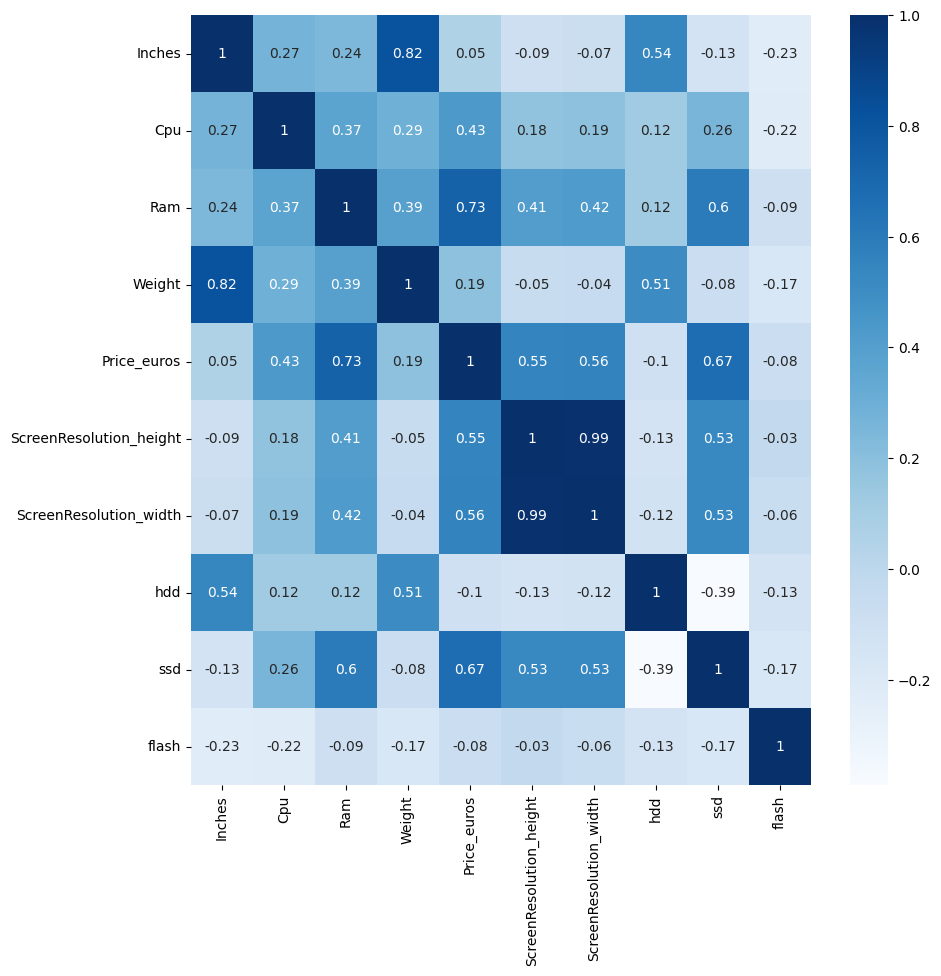

In [28]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr().round(2), annot=True, cmap='Blues')

### Стандартизация

In [29]:
from sklearn.preprocessing import StandardScaler
y = df['Price_euros']
X = df.drop(columns=['Price_euros']).select_dtypes(include=['number'])

std = StandardScaler()
X_std = std.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)

X_std

,Inches,Cpu,Ram,Weight,ScreenResolution_height,ScreenResolution_width,hdd,ssd,flash
0,-1.240338,-0.998043,-0.071903,-1.082018,-0.599985,-0.925808,-0.811957,-0.987946,7.156720
1,0.251376,0.792552,1.505684,-0.330283,2.616570,2.032872,-0.811957,1.788302,-0.167742
2,-1.240338,1.588372,-0.071903,-1.035994,1.901780,1.375388,-0.811957,0.400178,-0.167742
3,0.393444,1.389417,-0.860696,0.083938,-1.071746,-1.077851,0.133242,-0.987946,-0.167742
4,0.251376,-0.202223,1.505684,-0.008111,2.616570,2.032872,-0.811957,-0.987946,14.481182
...,...,...,...,...,...,...,...,...,...
1103,0.393444,0.394642,-0.860696,0.237353,-1.071746,-1.077851,0.133242,-0.987946,-0.167742
1104,-0.743100,0.394642,-0.860696,-0.376308,0.043326,0.060419,-0.811957,-0.293884,-0.167742
1105,-0.743100,-1.395953,-1.255092,-0.836554,-1.071746,-1.077851,-0.811957,-0.987946,3.494489
1106,0.393444,0.394642,-0.466299,0.222012,-1.071746,-1.077851,1.123811,-0.987946,-0.167742


### Работа с категориальными признаками

#### Gpu

In [30]:

def get_gpu(s):
    if s.count('Intel'):
        return 'Intel'
    elif s.count('Nvidia'):
        return 'Nvidia'
    elif s.count('AMD'):
        return 'AMD'

In [31]:
df['Gpu'] = df['Gpu'].apply(lambda x: get_gpu(x))
df.head()

,Company,TypeName,Inches,Cpu,Ram,Gpu,OpSys,Weight,Price_euros,ScreenResolution_height,ScreenResolution_width,hdd,ssd,flash
0,Apple,Ultrabook,13.3,1.8,8,Intel,macOS,1.34,898.94,900,1440,0.0,0.0,128.0
1,Apple,Ultrabook,15.4,2.7,16,AMD,macOS,1.83,2537.45,1800,2880,0.0,512.0,0.0
2,Apple,Ultrabook,13.3,3.1,8,Intel,macOS,1.37,1803.60,1600,2560,0.0,256.0,0.0
3,Acer,Notebook,15.6,3.0,4,AMD,Windows 10,2.10,400.00,768,1366,500.0,0.0,0.0
4,Apple,Ultrabook,15.4,2.2,16,Intel,Mac OS X,2.04,2139.97,1800,2880,0.0,0.0,256.0


In [32]:
columns_obj = df.select_dtypes(['object']).columns.values
for col in columns_obj:
    ohe = pd.get_dummies(df[col])
    X_std = pd.merge(X_std, ohe, left_index=True, right_index=True)

In [33]:
X_std.head()

,Inches,Cpu,Ram,Weight,ScreenResolution_height,ScreenResolution_width,hdd,ssd,flash,Acer,...,Nvidia,Android,Chrome OS,Linux,Mac OS X,No OS,Windows 10,Windows 10 S,Windows 7,macOS
0,-1.240338,-0.998043,-0.071903,-1.082018,-0.599985,-0.925808,-0.811957,-0.987946,7.156720,0,...,0,0,0,0,0,0,0,0,0,1
1,0.251376,0.792552,1.505684,-0.330283,2.616570,2.032872,-0.811957,1.788302,-0.167742,0,...,0,0,0,0,0,0,0,0,0,1
2,-1.240338,1.588372,-0.071903,-1.035994,1.901780,1.375388,-0.811957,0.400178,-0.167742,0,...,0,0,0,0,0,0,0,0,0,1
3,0.393444,1.389417,-0.860696,0.083938,-1.071746,-1.077851,0.133242,-0.987946,-0.167742,1,...,0,0,0,0,0,0,1,0,0,0
4,0.251376,-0.202223,1.505684,-0.008111,2.616570,2.032872,-0.811957,-0.987946,14.481182,0,...,0,0,0,0,1,0,0,0,0,0


### Разделение данные

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.15, random_state=42)

print(f'Train dataset size: {X_train.shape}, {y_train.shape}')
print(f'Test dataset size: {X_test.shape}, {y_test.shape}')

Train dataset size: (941, 45), (941,)
Test dataset size: (167, 45), (167,)


In [36]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [37]:
y_pred = model.predict(X_test)
y_pred

array([1052.34072536,  830.96289325, 1929.58522114, 1079.07607694,
        268.46694294, 1008.0455902 , 1257.88064095, 1479.83594231,
       1876.55575099, 1720.72666541,  438.15118192,  531.06524339,
        680.58063252, 1256.52084439, 1092.29799347, 1000.83526815,
        629.95515557, 1475.6927346 , 1768.26087135,  773.41373555,
       1129.66526167, 1670.57907885,  773.61590763,  819.50132114,
       1186.01368345, 1109.96303431,  765.96677935,  466.77841101,
       1626.19471095, 1816.5688662 , 2898.2738913 ,  946.01263728,
        996.7717022 , 1766.62546259,  344.71921297, 1261.26586906,
       1201.9504329 ,  789.73046246,  614.07815398, 1758.81818259,
       2006.48502572, 1229.57794269,  743.49862216, 1818.48881198,
       1736.06692796, 1274.18931182, 1726.50777891, 1670.57907885,
        769.33606117,  476.74720348,  443.25073267, 1661.00632368,
       1316.0749623 ,  506.99495702, 1890.60517752, 1238.8645751 ,
        696.94150135,  743.37692465, 1364.72900957,  609.40297

In [38]:
from sklearn import metrics 

print("MAE", metrics.mean_absolute_error(y_test, y_pred))
print("MSE", metrics.mean_squared_error(y_test, y_pred))
print("R2 Score:", model.score(X_test, y_test))

MAE 252.17706718101027
MSE 121860.07621929888
R2 Score: 0.7620480316159386


### Подготовка тестовых данных

In [39]:
dft = pd.read_csv('Price_euros_test.csv')
dft.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
0,86,Acer,Aspire 3,Notebook,15.6,1366x768,AMD A9-Series 9420 3GHz,4GB,1TB HDD,AMD Radeon R5,Windows 10,2.1kg
1,1249,Razer,Blade Pro,Gaming,14.0,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,1TB SSD,Nvidia GeForce GTX 1060,Windows 10,1.95kg
2,122,Asus,VivoBook S15,Notebook,15.6,Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,8GB,256GB SSD,Nvidia GeForce 940MX,Windows 10,1.7kg
3,993,Asus,Rog GL753VE-DS74,Gaming,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1050 Ti,Windows 10,2.99kg
4,739,Dell,Inspiron 3567,Notebook,15.6,1366x768,Intel Core i5 7200U 2.5GHz,12GB,1TB HDD,Intel HD Graphics 620,Windows 10,2.25kg


In [40]:
for key in dft.keys():
    dft[key] = dft[key].fillna(dft[key].mode()[0])

dft['ScreenResolution_height'] = [int(x.split('x')[1]) for x in dft['ScreenResolution']]
dft['ScreenResolution_width'] = [int(x.split('x')[0].split()[-1]) for x in dft['ScreenResolution']]
dft = dft.drop('ScreenResolution', axis=1)

dft['Cpu'] = [float(x.split()[-1][:-3]) for x in dft['Cpu']]

dft['Ram'] = [int(x[:-2]) for x in dft['Ram']]

dft['hdd'] = [memory(x)['hdd'] for x in dft['Memory']]
dft['ssd'] = [memory(x)['ssd'] for x in dft['Memory']]
dft['flash'] = [memory(x)['flash'] for x in dft['Memory']]
dft = dft.drop('Memory', axis = 1)

dft['Weight'] = [float(x[:-2]) for x in dft['Weight']]

dft = dft.drop('laptop_ID', axis=1)
dft = dft.drop('Product', axis=1)

dft['Gpu'] = dft['Gpu'].apply(lambda x: get_gpu(x))

dft.head()

,Company,TypeName,Inches,Cpu,Ram,Gpu,OpSys,Weight,ScreenResolution_height,ScreenResolution_width,hdd,ssd,flash
0,Acer,Notebook,15.6,3.0,4,AMD,Windows 10,2.10,768,1366,1024.0,0.0,0.0
1,Razer,Gaming,14.0,2.8,16,Nvidia,Windows 10,1.95,1080,1920,0.0,1024.0,0.0
2,Asus,Notebook,15.6,1.8,8,Nvidia,Windows 10,1.70,1080,1920,0.0,256.0,0.0
3,Asus,Gaming,17.3,2.8,16,Nvidia,Windows 10,2.99,1080,1920,1024.0,256.0,0.0
4,Dell,Notebook,15.6,2.5,12,Intel,Windows 10,2.25,768,1366,1024.0,0.0,0.0


### Стандартизация тестовых данных

In [41]:
from sklearn.preprocessing import StandardScaler
Xt = dft.select_dtypes(include=['number'])

std = StandardScaler()
Xt_std = std.fit_transform(Xt)
Xt_std = pd.DataFrame(Xt_std, columns=Xt.columns)

Xt_std

,Inches,Cpu,Ram,Weight,ScreenResolution_height,ScreenResolution_width,hdd,ssd,flash
0,0.453244,1.381592,-0.882134,0.066019,-1.056033,-1.054731,1.274723,-1.016890,-0.162548
1,-0.654134,0.970905,1.458222,-0.155993,0.028962,0.046057,-0.743487,4.375414,-0.162548
2,0.453244,-1.082528,-0.102016,-0.526014,0.028962,0.046057,-0.743487,0.331186,-0.162548
3,1.629833,0.970905,1.458222,1.383293,0.028962,0.046057,1.274723,0.331186,-0.162548
4,0.453244,0.354875,0.678103,0.288032,-1.056033,-1.054731,1.274723,-1.016890,-0.162548
...,...,...,...,...,...,...,...,...,...
190,0.453244,-0.055811,-0.882134,0.021617,0.028962,0.046057,0.241967,-1.016890,-0.162548
191,0.453244,-1.082528,-0.102016,0.214028,0.028962,0.046057,1.274723,-1.016890,-0.162548
192,-1.138612,0.765562,-0.102016,-1.088446,0.028962,0.046057,-0.743487,0.331186,-0.162548
193,0.453244,0.765562,1.458222,0.051218,0.028962,0.046057,-0.743487,1.679262,-0.162548


### Работа с категориальными данными

In [42]:
columns_obj = dft.select_dtypes(['object']).columns.values
for col in columns_obj:
    ohe = pd.get_dummies(dft[col])
    Xt_std = pd.merge(Xt_std, ohe, left_index=True, right_index=True)

In [43]:
Xt_std.head()

,Inches,Cpu,Ram,Weight,ScreenResolution_height,ScreenResolution_width,hdd,ssd,flash,Acer,...,Intel,Nvidia,Chrome OS,Linux,Mac OS X,No OS,Windows 10,Windows 10 S,Windows 7,macOS
0,0.453244,1.381592,-0.882134,0.066019,-1.056033,-1.054731,1.274723,-1.016890,-0.162548,1,...,0,0,0,0,0,0,1,0,0,0
1,-0.654134,0.970905,1.458222,-0.155993,0.028962,0.046057,-0.743487,4.375414,-0.162548,0,...,0,1,0,0,0,0,1,0,0,0
2,0.453244,-1.082528,-0.102016,-0.526014,0.028962,0.046057,-0.743487,0.331186,-0.162548,0,...,0,1,0,0,0,0,1,0,0,0
3,1.629833,0.970905,1.458222,1.383293,0.028962,0.046057,1.274723,0.331186,-0.162548,0,...,0,1,0,0,0,0,1,0,0,0
4,0.453244,0.354875,0.678103,0.288032,-1.056033,-1.054731,1.274723,-1.016890,-0.162548,0,...,1,0,0,0,0,0,1,0,0,0


In [160]:
test_columns = Xt_std.columns.values
train_columns = X_std.columns.values
for col in train_columns:
    if (col not in test_columns):
        Xt_std[col] = 0
Xt_std = Xt_std[train_columns]

In [161]:
yt_pred = model.predict(Xt_std)

In [162]:
result_2 = pd.DataFrame({'Index': [i for i in range(0, Xt_std.shape[0])], 'Price_euros': yt_pred})
result_2

,Index,Price_euros
0,0,-3677.00
1,1,9574.25
2,2,-1011.00
3,3,5654.00
4,4,758.25
...,...,...
190,190,-3402.50
191,191,-1780.25
192,192,253.25
193,193,6243.50


In [163]:
result_2.to_csv('result_2.csv', index=False)